In [1]:
import xarray as xr
import os
import matplotlib.pyplot as plt
from matplotlib import colors
import glob
import re
import numpy as np
from src.hls_funcs.masks import mask_hls

In [2]:
#wkDIR = '/project/cper_neon_aop/hls_nrt/'
#outDIR = '/90daydata/cper_neon_aop/hls_nrt/' + prefix

wkDIR = os.getcwd()
outDIR_base = 'data/hls_nrt/'

cluster_loc = 'local'

In [3]:
cmap_mask = colors.ListedColormap(['black', 'green', 'red', 'blue'])
boundaries = [0, 0.5, 1.5, 2.5, 3.5]
norm_mask = colors.BoundaryNorm(boundaries, cmap_mask.N, clip=True)

In [4]:
yr = 2022

#prefix = 'redtop' 
prefix = 'cper'

outDIR = os.path.join(outDIR_base, prefix)


In [5]:
os.chdir(wkDIR)
if cluster_loc == 'local':
    print('   setting up Local cluster...')
    from dask.distributed import LocalCluster, Client
    import dask
    smth_chunks = {'y': 30, 'x': 30, 'time':-1}
    cluster = LocalCluster(n_workers=8, threads_per_worker=2)
    client = Client(cluster)
    display(client)
elif cluster_loc == 'hpc':
    from dask.distributed import LocalCluster, Client
    import dask_jobqueue as jq
    import dask
    from jupyter_server import serverapp
    
    # get the server address for porting
    try:
        jupServer = [x for x in serverapp.list_running_servers()][0]
    except IndexError:
        # manually copy/paste the server address
        jupServer = {'base_url': '/node/ceres19-compute-98-eth.scinet.local/17710/'}
    print('   setting up moderate cluster on HPC...')
    smth_chunks = {'y': 10, 'x': 10, 'time':-1}
    dask.config.set({'distributed.dashboard.link': jupServer['base_url'] + 'proxy/{port}/status'})
    partition='short',#'short','debug', 'mem', 'mem-low',
    num_processes = 4
    num_threads_per_processes = 2
    mem = 2.5*num_processes*num_threads_per_processes
    n_cores_per_job = num_processes*num_threads_per_processes
    clust = jq.SLURMCluster(queue=partition,
                            processes=num_processes,
                            cores=n_cores_per_job,
                            memory=str(mem)+'GB',
                            interface='ib0',
                            #interface='enp24s0f0',
                            local_directory='$TMPDIR',
                            death_timeout=30,
                            walltime='02:00:00',
                            job_extra=["--output=/dev/null","--error=/dev/null"])
    client=Client(clust)
    #Scale Cluster 
    num_jobs=20
    clust.scale(jobs=num_jobs)
    try:
        client.wait_for_workers(n_workers=num_jobs*num_processes, timeout=60)
    except dask.distributed.TimeoutError as e:
        print(str(num_jobs*num_processes) + ' workers not available. Continuing with available workers.')
        #print(e)
        pass
    display(client)

if not os.path.exists(outDIR):
    os.mkdir(outDIR)

   setting up Local cluster...


/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/distributed/node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33225 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:42161' processes=8 threads=16, memory=15.49 GiB>

In [6]:
nc_flist = list(filter(os.path.isfile, 
                    glob.glob(os.path.join(outDIR,
                              prefix + 
                              '_hls_tmp/' + 'hls_ds_' + str(yr) + '*.nc'))))
if len(nc_flist) > 0:
    nc_flist.sort(key=lambda x: os.path.getctime(x))
    nc_f = nc_flist[-1]
else:
    print('ERROR: No temp nc file found')

hls_ds = xr.open_dataset(nc_f)
hls_atsa = xr.open_dataset(re.sub('hls_ds_', 'hls_atsa_', nc_f))

In [7]:
hls_ds = xr.merge([hls_ds, hls_atsa], join='inner')
#hls_mask = mask_hls(hls_ds['FMASK'], mask_types=['all'])
hls_mask = mask_hls(hls_ds['FMASK'], mask_types=[
    'cirrus',
    'cloud',
    'cloud_adj',
    'shadow',
    'snow',
    'water',
    'high_aerosol'
])
#hls_ds = hls_ds.where(hls_mask == 0)
#hls_ds = hls_ds.where(hls_ds['ATSA'] == 1)

In [8]:
partial_mask = (hls_ds['NIR1'].isnull().sum(dim=['y', 'x'])/np.product(hls_ds['NIR1'].shape[1:])) < 0.25
#hls_ds = hls_ds.where(partial_mask, drop=True)
#hls_mask = hls_mask.where(partial_mask, drop=True)

In [9]:
hls_ds

<xarray.Dataset>
Dimensions:      (time: 77, y: 323, x: 323)
Coordinates:
  * time         (time) datetime64[ns] 2021-11-03 2021-11-04 ... 2022-06-25
  * x            (x) float64 5.176e+05 5.176e+05 ... 5.272e+05 5.272e+05
  * y            (y) float64 4.524e+06 4.524e+06 ... 4.515e+06 4.515e+06
Data variables: (12/13)
    BLUE         (time, y, x) float64 ...
    GREEN        (time, y, x) float64 ...
    RED          (time, y, x) float64 ...
    NIR1         (time, y, x) float64 2.023e+03 2.132e+03 ... 2.071e+03
    SWIR1        (time, y, x) float64 ...
    SWIR2        (time, y, x) float64 ...
    ...           ...
    SZA          (time, y, x) float64 ...
    SAA          (time, y, x) float64 ...
    VZA          (time, y, x) float64 ...
    VAA          (time, y, x) float64 ...
    maskcov_pct  (time) float64 ...
    ATSA         (time, y, x) float64 ...
Attributes:
    crs:         epsg:32613
    transform:   [ 3.00000e+01  0.00000e+00  5.17590e+05  0.00000e+00 -3.0000...
    resolution:  30

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-1 :  2022-06-25T00:00:00.000000000


<AxesSubplot:>

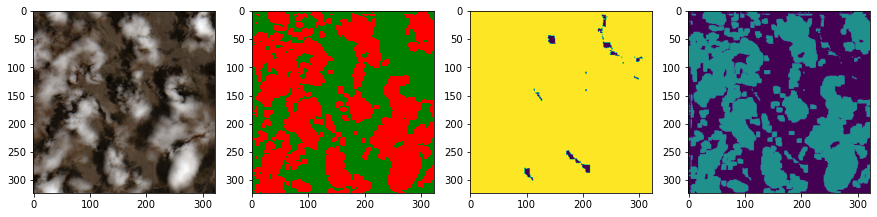

In [10]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from rasterio.plot import show
t = -1
print(t, ': ', hls_ds.time.values[t])
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15, 12))
show([hls_ds.isel(time=t)['RED'].values/hls_ds.isel(time=t)['RED'].max().values,
     hls_ds.isel(time=t)['GREEN'].values/hls_ds.isel(time=t)['GREEN'].max().values,
     hls_ds.isel(time=t)['BLUE'].values/hls_ds.isel(time=t)['BLUE'].max().values], ax=axs[0])
show(hls_ds['ATSA'].isel(time=t).values, cmap=cmap_mask, norm=norm_mask, ax=axs[1])
show(hls_mask.isel(time=t).values, ax=axs[2], vmin=0, vmax=1)
show((hls_ds['ATSA'].isel(time=t) != 1) - hls_mask.isel(time=t), ax=axs[3], vmin=-1, vmax=1)

57 :  2022-05-11T00:00:00.000000000


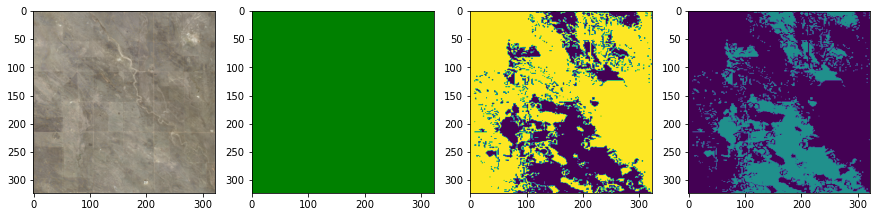

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


58 :  2022-05-13T00:00:00.000000000


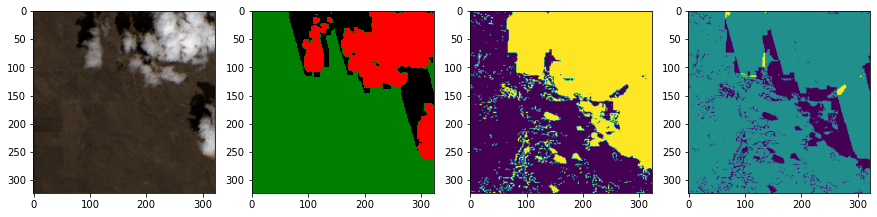

59 :  2022-05-14T00:00:00.000000000


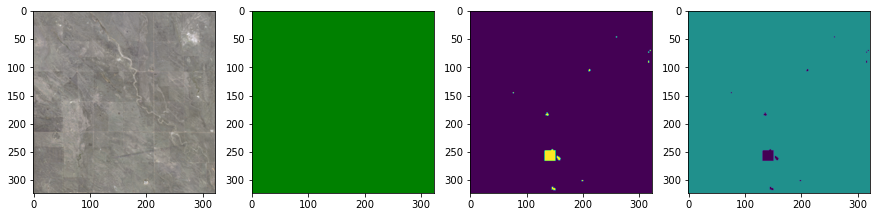

60 :  2022-05-16T00:00:00.000000000


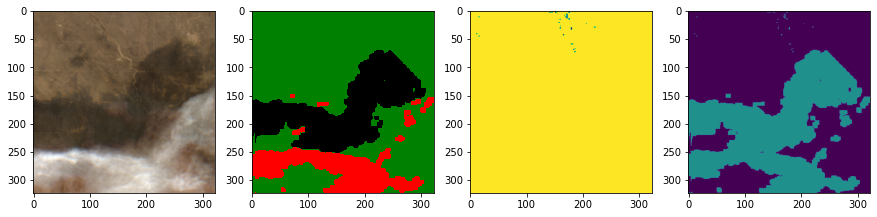

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


61 :  2022-05-18T00:00:00.000000000


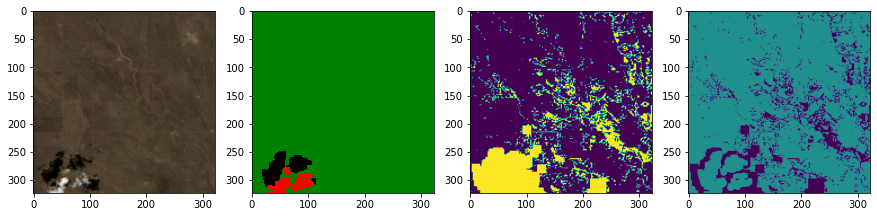

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


62 :  2022-05-23T00:00:00.000000000


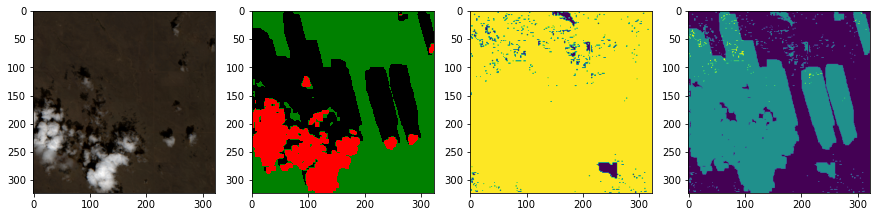

63 :  2022-05-26T00:00:00.000000000


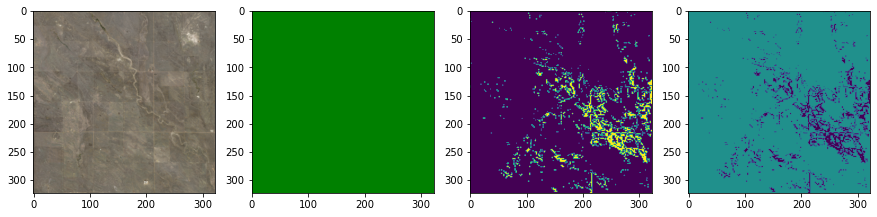

64 :  2022-05-29T00:00:00.000000000


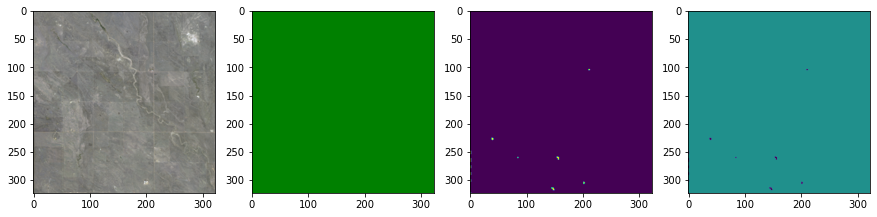

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


65 :  2022-05-30T00:00:00.000000000


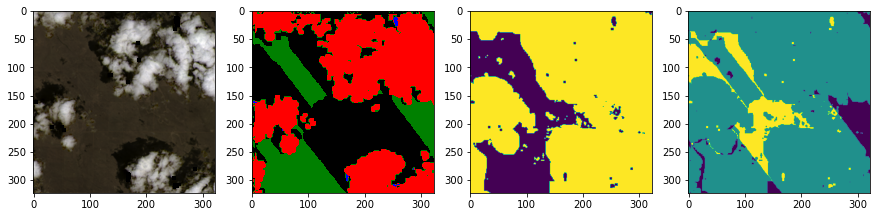

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


66 :  2022-05-31T00:00:00.000000000


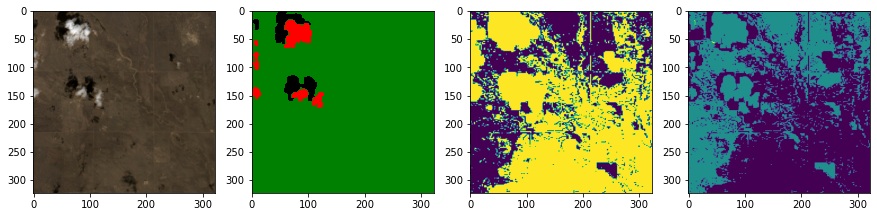

67 :  2022-06-02T00:00:00.000000000


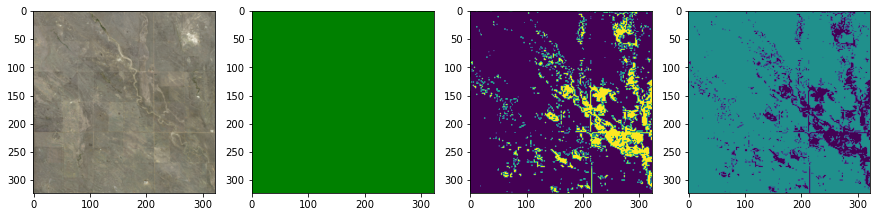

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


68 :  2022-06-06T00:00:00.000000000


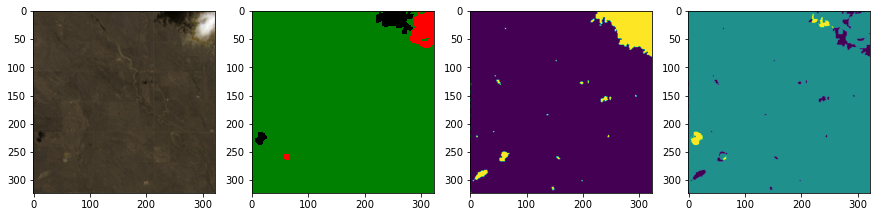

69 :  2022-06-07T00:00:00.000000000


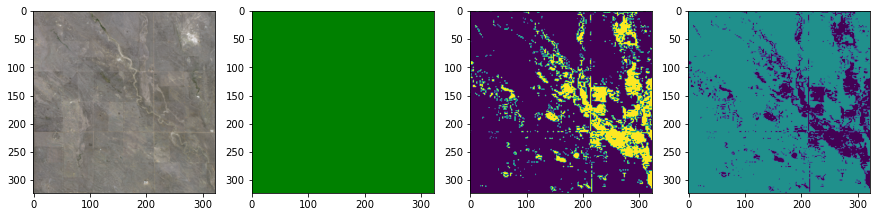

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


70 :  2022-06-12T00:00:00.000000000


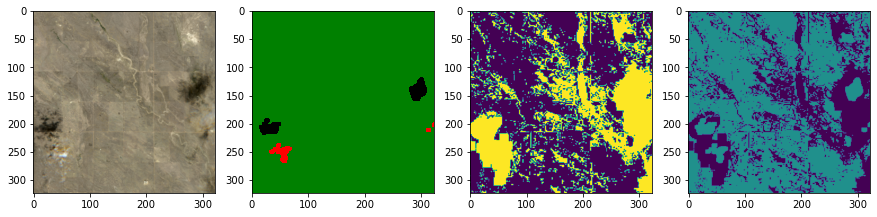

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


71 :  2022-06-14T00:00:00.000000000


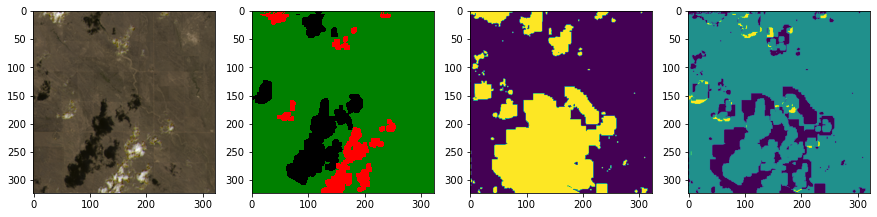

72 :  2022-06-15T00:00:00.000000000


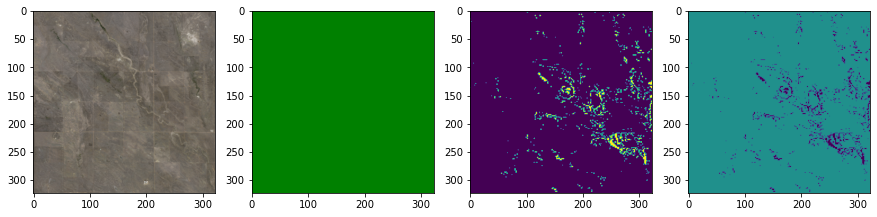

73 :  2022-06-17T00:00:00.000000000


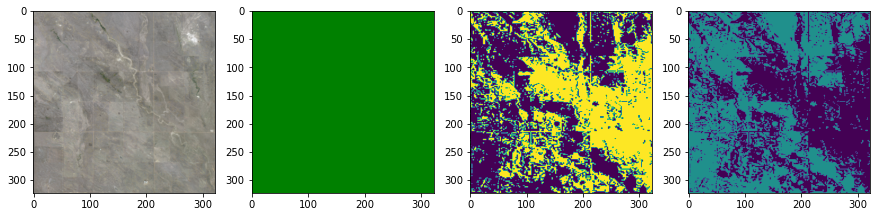

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


74 :  2022-06-20T00:00:00.000000000


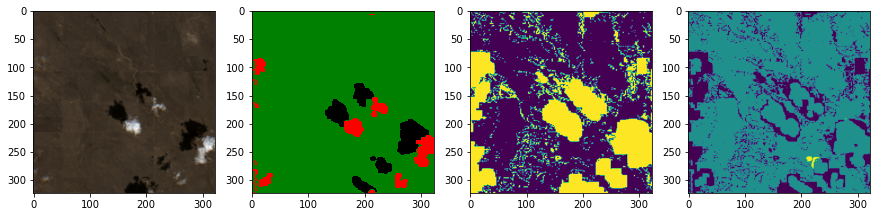

75 :  2022-06-22T00:00:00.000000000


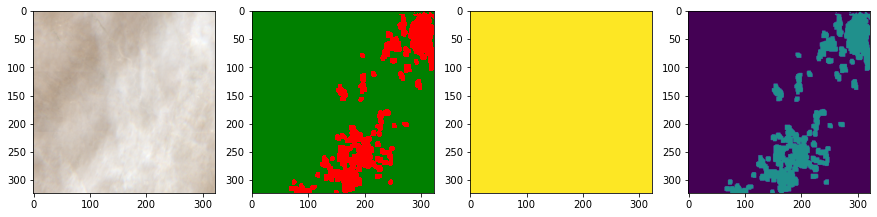

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


76 :  2022-06-25T00:00:00.000000000


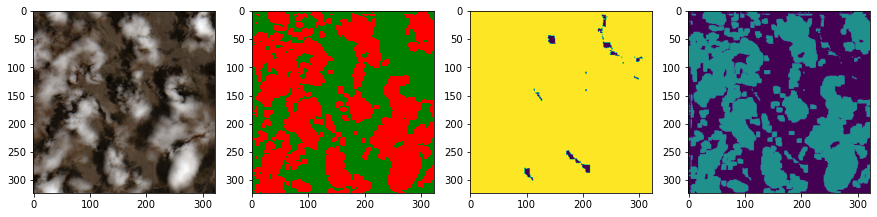

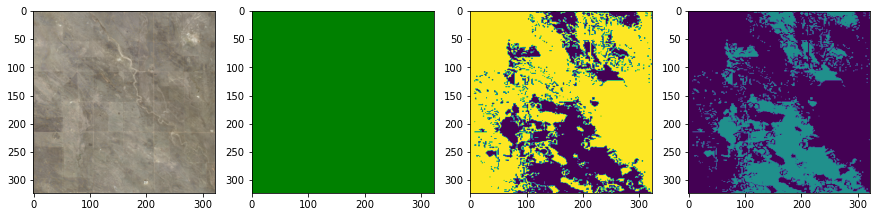

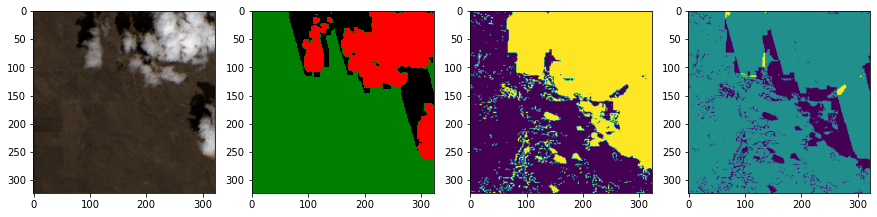

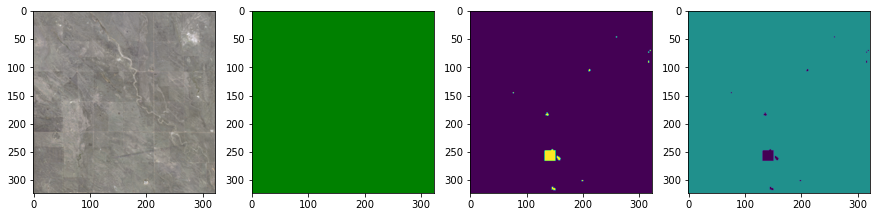

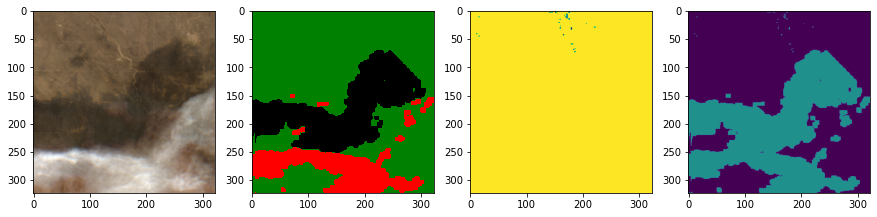

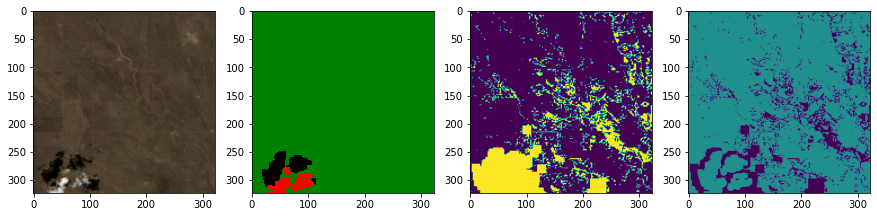

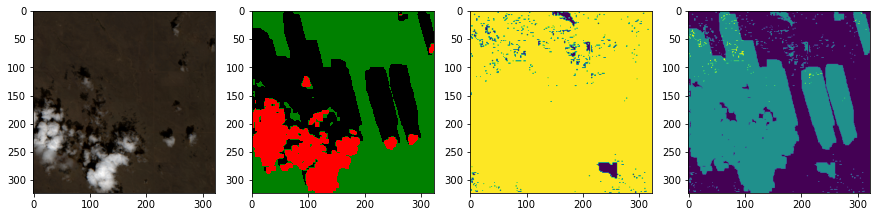

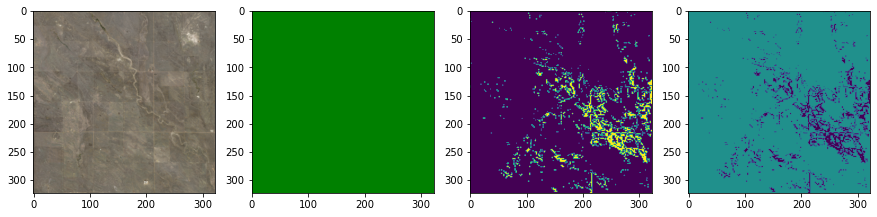

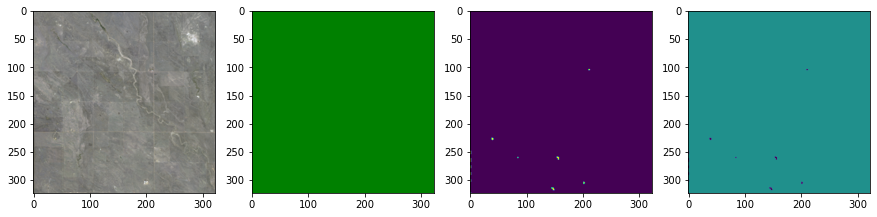

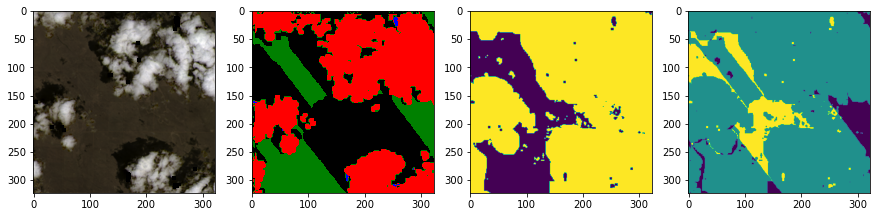

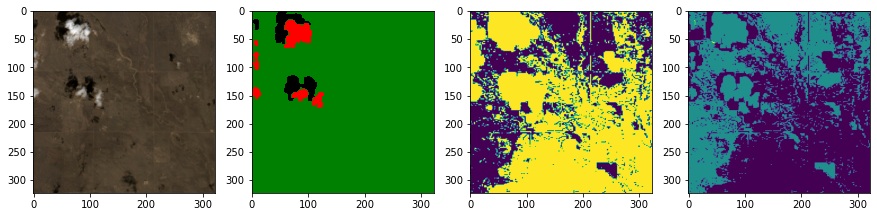

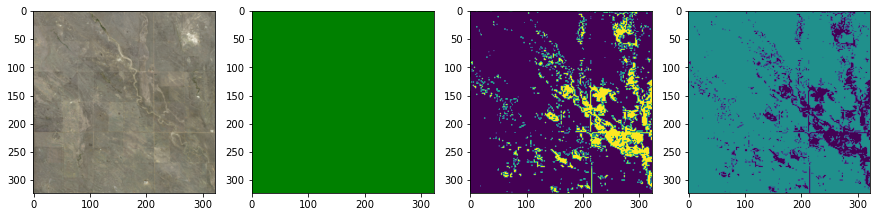

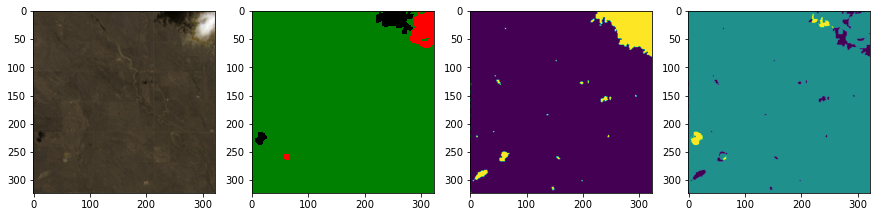

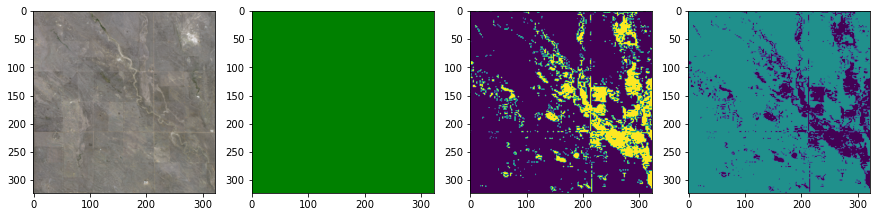

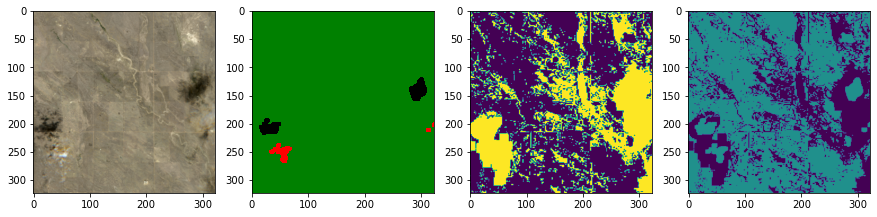

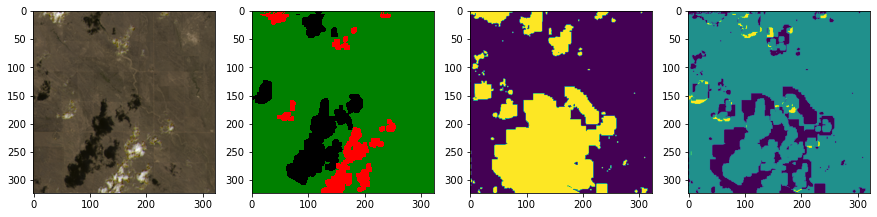

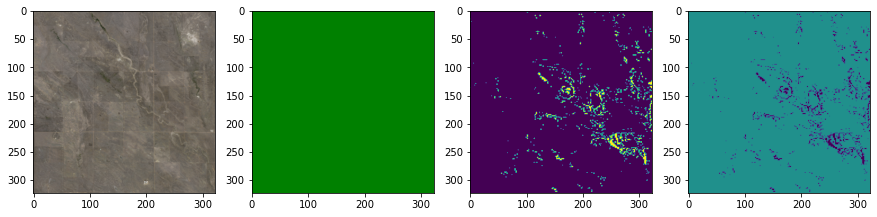

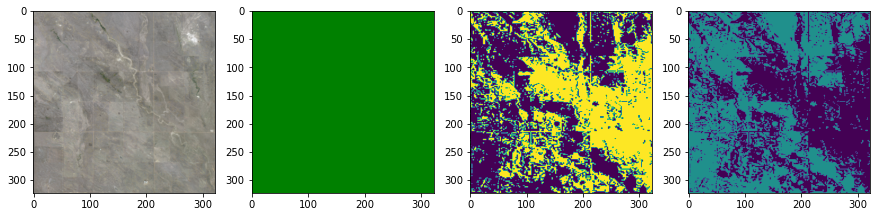

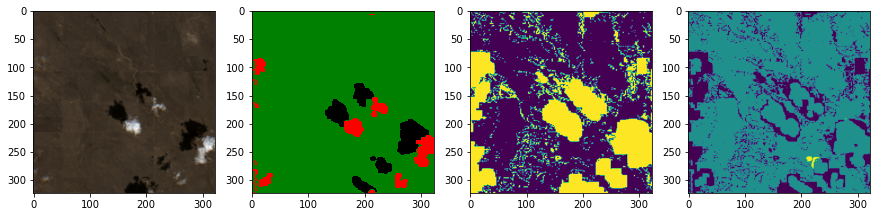

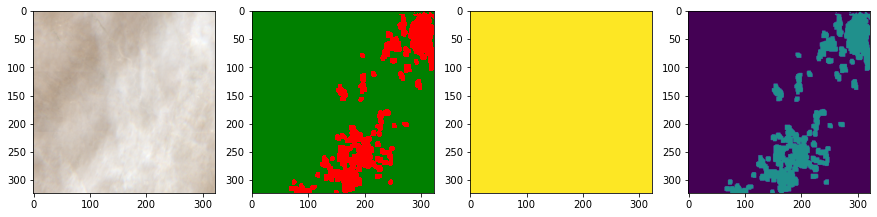

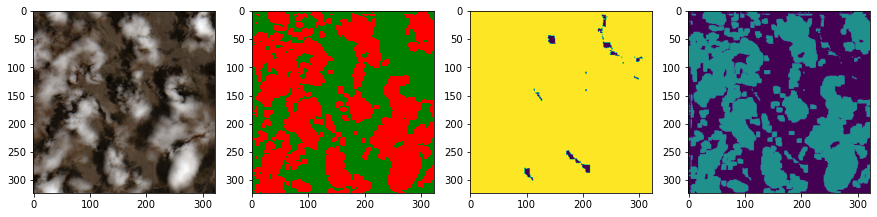

2022-06-27 18:11:44,357 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-06-27 18:11:44,358 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-06-27 18:11:44,359 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-06-27 18:11:44,360 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-06-27 18:11:44,363 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-06-27 18:11:44,363 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-06-27 18:11:44,364 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-06-27 18:11:44,365 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-06-27 18:11:44,591 - distributed.nanny - WARNING - Restarting worker
2022-06-27 18:11:44,605 - distributed.nanny - WARNING - Restarting worker
2022-06-27 18:11:44,609 - distributed.nanny - WARNING - Restarting worker
2022-06-27 18:11:44,618 - distributed.nanny - WARNING - Restarting worker
2022-06-

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output
from rasterio.plot import show
import pylab as pl
from IPython import display
#t = 42
for t in range(len(hls_ds.time.values)-20, len(hls_ds.time.values)):
    print(t, ': ', hls_ds.time.values[t])
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15, 12))
    show([hls_ds.isel(time=t)['RED'].values/hls_ds.isel(time=t)['RED'].max().values,
         hls_ds.isel(time=t)['GREEN'].values/hls_ds.isel(time=t)['GREEN'].max().values,
         hls_ds.isel(time=t)['BLUE'].values/hls_ds.isel(time=t)['BLUE'].max().values], ax=axs[0])
    show(hls_ds['ATSA'].isel(time=t).values, cmap=cmap_mask, norm=norm_mask, ax=axs[1])
    show(hls_mask.isel(time=t).values, ax=axs[2], vmin=0, vmax=1)
    show((hls_ds['ATSA'].isel(time=t) != 1) - hls_mask.isel(time=t), ax=axs[3], vmin=-1, vmax=1 )
    display.display(pl.gcf())
    #plt.draw()
    #plt.pause(4)
    #print("Press any key to continue...")
    #while True:
    #    if plt.waitforbuttonpress():
    #        break  # Exit loop if user presses a key.
    #plt.close(fig)
    #clear_output(wait  = True)